In [ ]:
## Notebook env: mirtud_env (R kernel)
## g1, g2, s, and apoptosis specific analysis -- the previous notebook is for s-phase and g2m-phase
## we validated the growth rate from mitosis analysis

In [1]:
library(Seurat)
library(tidyr)
library(dplyr)
library(ggplot2)
library(ggrepel)
library(ggpubr)
library(escape)

## add libPath for Volcano plot package
.libPaths('/home/ssobti/projects/mir_tud/mirtud_conda_extras')
library(EnhancedVolcano)

The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [2]:
adata.R = readRDS('/home/ssobti/projects/mir_tud/101423_filtered_data/tRF_normalized_integrated_seurat.rds')
head(adata.R@meta.data)

,nCount_RNA,nFeature_RNA,orig.ident,sample,barcode,guide,lor,pvalue,adj_pvalue,max_umi,n_umi,m_umi,v_umi,log_max_umi,log_n_umi,log_m_umi,percent.mt,integrated_snn_res.0.5,seurat_clusters,guide_group
,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>
tRF_1:AAACCCAAGGCCTTGC-1,20239,5372,tRF,tRF_1,AAACCCAAGGCCTTGC,TuD_NC_01,2.144148,1.652448e-15,8.377661e-09,23,33,0.1506849,2.458841,1.361728,1.518514,-0.82193017,6.363951,4,control,control
tRF_1:AAACCCACATATACCG-1,35201,7086,tRF,tRF_1,AAACCCACATATACCG,tRF_Arg_ACG_2,7.473168,2.865581e-322,1.452806e-315,182,214,0.9771689,151.260944,2.260071,2.330414,-0.01003034,6.295276,3,T3,target
tRF_1:AAACCCACATGACAGG-1,32207,6695,tRF,tRF_1,AAACCCACATGACAGG,TuD_NC_01,2.336330,3.615579e-22,1.833044e-15,36,53,0.2420091,5.973273,1.556303,1.724276,-0.61616825,6.237774,1,control,control
tRF_1:AAACCCACATGACGGA-1,38017,7151,tRF,tRF_1,AAACCCACATGACGGA,tRF_Arg_ACG_2,1.160519,2.865581e-322,1.452806e-315,214,372,1.6986301,237.780319,2.330414,2.570543,0.23009883,6.831154,3,T3,target
tRF_1:AAACCCAGTCAACCAT-1,28633,6505,tRF,tRF_1,AAACCCAGTCAACCAT,TuD_NC_01,3.011825,9.624496e-26,4.879475e-19,38,51,0.2328767,6.638180,1.579784,1.707570,-0.63287394,8.619425,4,control,control
tRF_1:AAACCCAGTTATCTTC-1,28000,6688,tRF,tRF_1,AAACCCAGTTATCTTC,tRF_Glu_CTC_2,4.656560,7.086097e-135,3.592545e-128,69,88,0.4018265,21.984584,1.838849,1.944483,-0.39596144,6.617857,2,T2,target


In [3]:
## G1 genes from GSEA website: https://www.gsea-msigdb.org/gsea/msigdb/cards/G1_PHASE
## S genes from GSEA website: https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/S_PHASE
## G2 genes from GSEA website: https://www.gsea-msigdb.org/gsea/msigdb/cards/REACTOME_G2_PHASE
## Apoptosis genes from GSEA website: https://www.gsea-msigdb.org/gsea/msigdb/human/geneset/APOPTOTIC_PROGRAM

g1_genes = 'CDC23,CDC25C,CDC6,CDK10,CDK2,CDK6,CDKN1C,E2F1,FOXO4,GFI1B,MAP3K11,PRUNE2,RB1,TAF1,TBRG4'
s_genes = 'ABL1,APBB1,APBB2,CDC7,CDK2AP1,CHMP1A,DDX11,MYO16,POLA1,POLD1,PTPRC,RCC1,TIMELESS,TIPIN'
g2_genes = 'E2F1,E2F3,CDK2,CCNA1,CCNA2'
apoptosis_genes = 'ACIN1,AIFM1,AIFM3,APAF1,BAD,BAK1,BAX,BBC3,BCL2L1,BCL2L10,BID,BIK,BNIP3,CDIP1,CASP2,CASP3,CASP7,CASP8,CASP8AP2,CASP9,CDKN2A,CECR2,CIDEA,COL4A3,CYCS,DEDD2,DFFA,DFFB,DIABLO,DNM1L,F2,F2R,FOXL2,GPX1,GZMA,GZMB,HIP1,IFI6,IFNB1,IFT57,LCK,MCL1,MOAP1,MTCH1,NDUFA13,NLRC4,PDIA2,PMAIP1,PPT1,PSEN2,SFN,SMAD3,SOD1,STAT1,TNFSF15,TOP2A,TP53,TPD52L1,VCP,VDAC1'

g1_genes = unlist(strsplit(g1_genes, ","))
s_genes = unlist(strsplit(s_genes, ","))
g2_genes = unlist(strsplit(g2_genes, ","))
apoptosis_genes = unlist(strsplit(apoptosis_genes, ","))

adata.R = AddModuleScore(object = adata.R, features = list(g1_genes), name = "g1_phase", ctrl = 30)
adata.R = AddModuleScore(object = adata.R, features = list(s_genes), name = "s_phase", ctrl = 30)
adata.R = AddModuleScore(object = adata.R, features = list(g2_genes), name = "g2_phase", ctrl = 30)
adata.R = AddModuleScore(object = adata.R, features = list(apoptosis_genes), name = "apoptosis", ctrl = 30)


#adata.R <- CellCycleScoring(object = adata.R, g2m.features = cc.genes$g2m.genes, s.features = cc.genes$s.genes)

Warning message:
“The following features are not present in the object: CDC23, CDK10, CDK2, CDK6, CDKN1C, E2F1, FOXO4, GFI1B, MAP3K11, PRUNE2, RB1, TAF1, TBRG4, not searching for symbol synonyms”


Warning message:
“The following features are not present in the object: ABL1, APBB1, APBB2, CDC7, CDK2AP1, CHMP1A, DDX11, MYO16, POLD1, PTPRC, RCC1, TIMELESS, TIPIN, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: E2F1, E2F3, CDK2, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: ACIN1, AIFM1, AIFM3, APAF1, BAD, BAK1, BAX, BBC3, BCL2L1, BCL2L10, BID, BIK, CDIP1, CASP2, CASP3, CASP7, CASP8, CASP8AP2, CASP9, CDKN2A, CIDEA, COL4A3, CYCS, DEDD2, DFFA, DFFB, DIABLO, DNM1L, F2, F2R, FOXL2, GPX1, GZMA, GZMB, IFI6, IFNB1, IFT57, MCL1, MOAP1, MTCH1, NDUFA13, NLRC4, PDIA2, PPT1, PSEN2, SMAD3, SOD1, STAT1, TNFSF15, TP53, TPD52L1, VCP, VDAC1, not searching for symbol synonyms”


In [4]:
head(adata.R@meta.data)

,nCount_RNA,nFeature_RNA,orig.ident,sample,barcode,guide,lor,pvalue,adj_pvalue,max_umi,⋯,log_n_umi,log_m_umi,percent.mt,integrated_snn_res.0.5,seurat_clusters,guide_group,g1_phase1,s_phase1,g2_phase1,apoptosis1
,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<fct>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
tRF_1:AAACCCAAGGCCTTGC-1,20239,5372,tRF,tRF_1,AAACCCAAGGCCTTGC,TuD_NC_01,2.144148,1.652448e-15,8.377661e-09,23,⋯,1.518514,-0.82193017,6.363951,4,control,control,-0.30140067,0.05898312,-0.19371714,-0.05299003
tRF_1:AAACCCACATATACCG-1,35201,7086,tRF,tRF_1,AAACCCACATATACCG,tRF_Arg_ACG_2,7.473168,2.865581e-322,1.452806e-315,182,⋯,2.330414,-0.01003034,6.295276,3,T3,target,-0.41374554,-0.04864330,0.03658290,0.12786032
tRF_1:AAACCCACATGACAGG-1,32207,6695,tRF,tRF_1,AAACCCACATGACAGG,TuD_NC_01,2.336330,3.615579e-22,1.833044e-15,36,⋯,1.724276,-0.61616825,6.237774,1,control,control,-0.15240053,-0.33416711,0.07390783,0.25471855
tRF_1:AAACCCACATGACGGA-1,38017,7151,tRF,tRF_1,AAACCCACATGACGGA,tRF_Arg_ACG_2,1.160519,2.865581e-322,1.452806e-315,214,⋯,2.570543,0.23009883,6.831154,3,T3,target,0.01168841,0.02699639,0.34497829,-0.01448267
tRF_1:AAACCCAGTCAACCAT-1,28633,6505,tRF,tRF_1,AAACCCAGTCAACCAT,TuD_NC_01,3.011825,9.624496e-26,4.879475e-19,38,⋯,1.707570,-0.63287394,8.619425,4,control,control,-0.21772404,-0.31823400,-0.10584519,-0.21884692
tRF_1:AAACCCAGTTATCTTC-1,28000,6688,tRF,tRF_1,AAACCCAGTTATCTTC,tRF_Glu_CTC_2,4.656560,7.086097e-135,3.592545e-128,69,⋯,1.944483,-0.39596144,6.617857,2,T2,target,-0.03917269,0.42831883,-0.30236969,-0.08250820


In [ ]:
## stopped here

In [5]:
## throw out guides with cells < 30
guides_above_cutoff = adata.R@meta.data$guide %>% table %>% as.data.frame %>% filter(Freq > 30) %>% pull('.') %>% as.character()
adata.R <- subset(adata.R, subset = guide %in% guides_above_cutoff)

In [ ]:
## select out 20 cells per guide for the analysis
## select 10 seeds for 10 samplings of 20 cells per guide -- also the random guides will contain 10 different random combinations of cells
## repeat three times and pick top guides from results

seeds_1 = c(145, 148, 200, 358, 616, 629, 649, 656, 687, 915) 
seeds_2 = c(191, 249, 390, 443, 494, 524, 641, 866, 938, 946) 
seeds_3 = c(132, 276, 277, 448, 610, 692, 728, 773, 833, 971)

seed_sets = list(seeds_1, seeds_2, seeds_3)
names(seed_sets) = c('seeds_1', 'seeds_2', 'seeds_3')
mitosis_scores_df_list_combined = list()

for (j in 1:length(seed_sets)){
    seeds = seed_sets[[j]]
    mitosis_scores_df_list = list()
    for (i in 1:length(seeds)){
        set.seed(seeds[i])
        adata.R@meta.data -> meta
        meta %>% group_by(guide) %>% sample_n(20) %>% ungroup -> meta  ## select 30 cells per guide

        ## get the median scores for each guide
        
        mitosis_scores_df = data.frame(score = meta$mitosis1, guide = meta$guide, type = ifelse(startsWith(meta$guide, 'TuD_NC'), 'control', 'guide'))
        mitosis_scores_df %>% group_by(guide) %>% summarise(score = median(score), type = unique(type)) -> mitosis_scores_df

        ## add bkg distribution of guide 
        ## this is just median scores for each guide where the cells are randomly assigned to guides
        ## Note: the number of cells assigned to each guide is kept the same
        
        meta$random_guide = sample(meta$guide, replace = FALSE)
        meta$random_guide = paste0('random_', meta$random_guide)
        mitosis_scores_df_random = data.frame(score = meta$mitosis1, guide = meta$random_guide, type = ifelse(startsWith(meta$random_guide, 'TuD_NC'), 'control', 'guide'))
        mitosis_scores_df_random %>% group_by(guide) %>% summarise(score = median(score), type = unique(type)) -> mitosis_scores_df_random

        mitosis_scores_df_list[[i]] = rbind(mitosis_scores_df, mitosis_scores_df_random)
        mitosis_scores_df_list[[i]]$zscore = scale(mitosis_scores_df_list[[i]]$score, center = TRUE, scale = TRUE)
        mitosis_scores_df_list[[i]]$pval = ifelse(mitosis_scores_df_list[[i]]$zscore > 0, 2*pnorm(mitosis_scores_df_list[[i]]$zscore, lower.tail = FALSE), 2*pnorm(mitosis_scores_df_list[[i]]$zscore, lower.tail = TRUE))
        noise_floor = mitosis_scores_df_list[[i]]$score[startsWith(as.character(mitosis_scores_df_list[[i]]$guide), 'random_')] %>% mean
        mitosis_scores_df_list[[i]] = mutate(mitosis_scores_df_list[[i]], score_ratio = score/abs(noise_floor))
    }
    names(mitosis_scores_df_list) = paste0('seed_', seeds)
    mitosis_scores_df_list_combined[[j]] = bind_rows(mitosis_scores_df_list, .id = 'random_start')
}

In [ ]:
## filter for p-val < 0.1 (zscore > 1.28 or < -1.28)
mitosis_scores_top_guides = list()
mitosis_scores_bottom_guides = list()

for (j in 1:length(seed_sets)){
    mitosis_scores_df_list_combined[[j]] %>% group_by(random_start) %>% filter(zscore > 1.28) %>% pull(guide) %>% as.character() -> mitosis_scores_top_guides[[j]]
    mitosis_scores_df_list_combined[[j]] %>% group_by(random_start) %>% filter(zscore < -1.28) %>% pull(guide) %>% as.character() -> mitosis_scores_bottom_guides[[j]]
    guides = unique(mitosis_scores_df_list_combined[[j]]$guide)

    mitosis_scores_top_guides[[j]] = table(mitosis_scores_top_guides[[j]]) %>% as.data.frame %>% arrange(-Freq)
    mitosis_scores_bottom_guides[[j]] = table(mitosis_scores_bottom_guides[[j]]) %>% as.data.frame %>% arrange(-Freq)

    noise_floor_mean = mitosis_scores_top_guides[[j]]$Freq[startsWith(as.character(mitosis_scores_top_guides[[j]]$Var1), 'random_')] %>% mean
    mitosis_scores_top_guides[[j]] = mitosis_scores_top_guides[[j]] %>% mutate(ratio_above_noise_floor = Freq/noise_floor_mean)

    noise_floor_mean = mitosis_scores_bottom_guides[[j]]$Freq[startsWith(as.character(mitosis_scores_bottom_guides[[j]]$Var1), 'random_')] %>% mean
    mitosis_scores_bottom_guides[[j]] = mitosis_scores_bottom_guides[[j]] %>% mutate(ratio_above_noise_floor = Freq/noise_floor_mean)

    guides_to_zero = setdiff(guides, unique(mitosis_scores_top_guides[[j]]$Var1))
    #guides_to_zero_df = data.frame(Var1 = guides_to_zero, Freq = 0, ratio_above_noise_floor = 0)
    #mitosis_scores_top_guides[[j]] = bind_rows(mitosis_scores_top_guides[[j]], guides_to_zero_df)
    mitosis_scores_top_guides[[j]]$Var1 = paste(mitosis_scores_top_guides[[j]]$Var1, j, sep = '_')
    mitosis_scores_bottom_guides[[j]]$Var1 = paste(mitosis_scores_bottom_guides[[j]]$Var1, j, sep = '_')

}

names(mitosis_scores_top_guides) = names(mitosis_scores_bottom_guides) = names(seed_sets)

Warning message:
“Using one column matrices in `filter()` was deprecated in dplyr 1.1.0.
ℹ Please use one dimensional logical vectors instead.”


In [ ]:
## top guides
names(mitosis_scores_df_list_combined) = names(seed_sets)
mitosis_scores_df_list_combined_sets = bind_rows(mitosis_scores_df_list_combined, .id = 'seed_set')
mitosis_scores_top_guides_combined = bind_rows(mitosis_scores_top_guides, .id = 'seed_set')
colnames(mitosis_scores_top_guides_combined)[colnames(mitosis_scores_top_guides_combined) == 'Var1'] = 'guide'
pvals = mitosis_scores_df_list_combined_sets %>% group_by(guide, seed_set) %>% summarize(final_pval = prod(pval)) %>% arrange(final_pval)
pvals$guide = paste(pvals$guide, stringr::str_sub(pvals$seed_set, -1), sep = '_')
## pvalues are here multiplication of p-values from each seed (in the end you get one p-val per seed set)
mitosis_scores_top_guides_combined_w_pvals = left_join(mitosis_scores_top_guides_combined, pvals, by = join_by(seed_set, guide))
mitosis_scores_top_guides_combined_w_pvals$final_pval_adjust = p.adjust(mitosis_scores_top_guides_combined_w_pvals$final_pval, method = 'fdr')

## bottom guides
mitosis_scores_bottom_guides_combined = bind_rows(mitosis_scores_bottom_guides, .id = 'seed_set')
colnames(mitosis_scores_bottom_guides_combined)[colnames(mitosis_scores_bottom_guides_combined) == 'Var1'] = 'guide'
pvals = mitosis_scores_df_list_combined_sets %>% group_by(guide, seed_set) %>% summarize(final_pval = prod(pval)) %>% arrange(final_pval)
pvals$guide = paste(pvals$guide, stringr::str_sub(pvals$seed_set, -1), sep = '_')
## pvalues are here multiplication of p-values from each seed (in the end you get one p-val per seed set)
mitosis_scores_bottom_guides_combined_w_pvals = left_join(mitosis_scores_bottom_guides_combined, pvals, by = join_by(seed_set, guide))
mitosis_scores_bottom_guides_combined_w_pvals$final_pval_adjust = p.adjust(mitosis_scores_bottom_guides_combined_w_pvals$final_pval, method = 'fdr')

## remove all those below noise floor
mitosis_scores_bottom_guides_combined_w_pvals = mitosis_scores_bottom_guides_combined_w_pvals %>% filter(ratio_above_noise_floor >= 1)
mitosis_scores_top_guides_combined_w_pvals = mitosis_scores_top_guides_combined_w_pvals %>% filter(ratio_above_noise_floor >= 1)

## combine and cleanup
mitosis_scores_bottom_guides_combined_w_pvals$ratio_above_noise_floor = -1*log2(mitosis_scores_bottom_guides_combined_w_pvals$ratio_above_noise_floor )
mitosis_scores_top_guides_combined_w_pvals$ratio_above_noise_floor = log2(mitosis_scores_top_guides_combined_w_pvals$ratio_above_noise_floor)
mitosis_scores_combined_w_pvals = bind_rows(mitosis_scores_bottom_guides_combined_w_pvals, mitosis_scores_top_guides_combined_w_pvals)
mitosis_scores_combined_w_pvals$guide = paste(mitosis_scores_combined_w_pvals$guide, c(rep('down', nrow(mitosis_scores_bottom_guides_combined_w_pvals)), rep('up', nrow(mitosis_scores_top_guides_combined_w_pvals))), sep = '_')

`summarise()` has grouped output by 'guide'. You can override using the
`.groups` argument.
`summarise()` has grouped output by 'guide'. You can override using the
`.groups` argument.


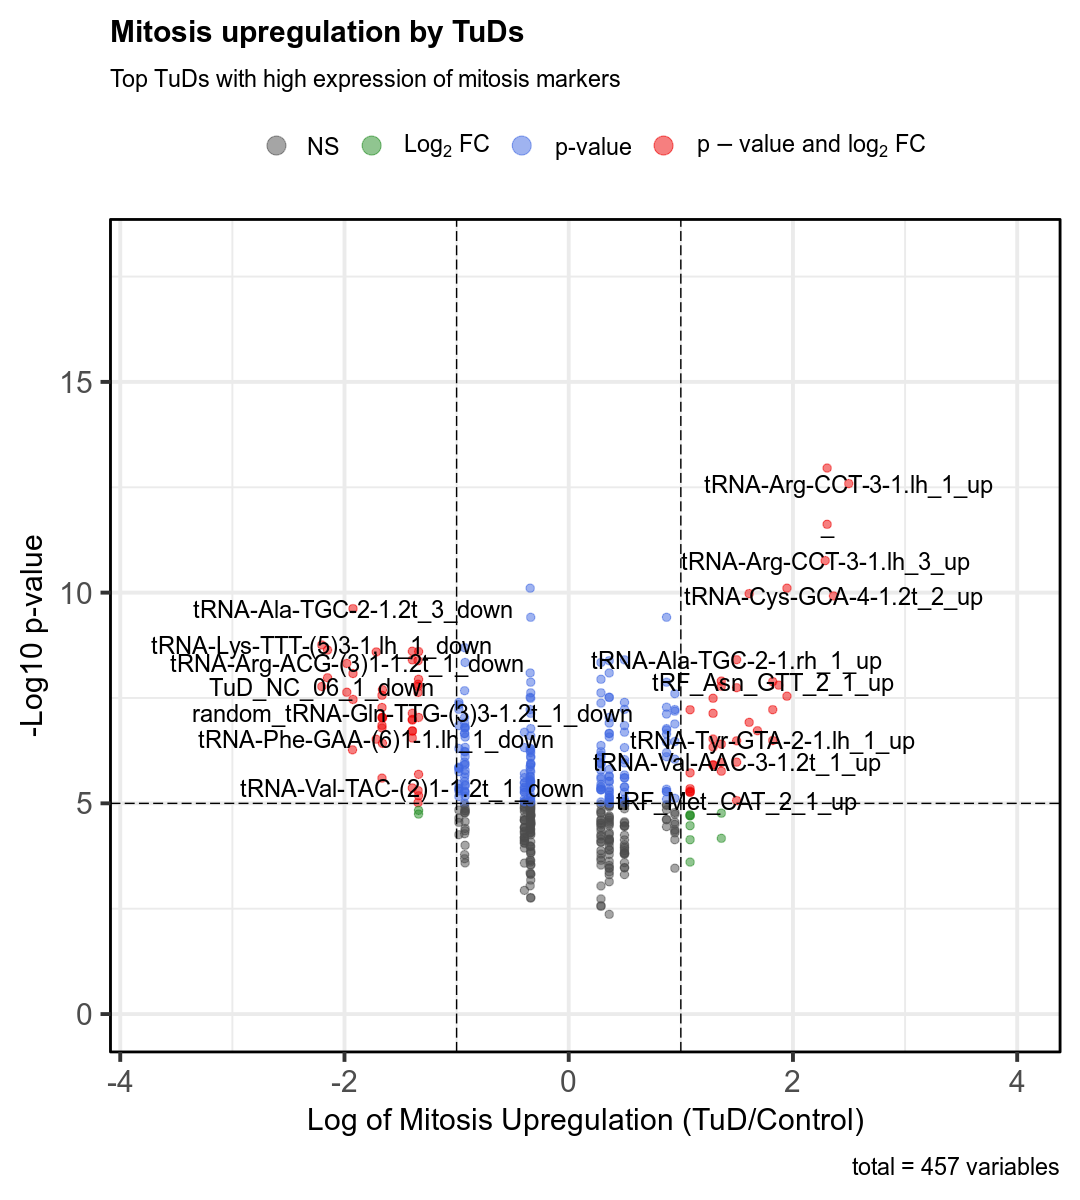

In [ ]:
## graph guides that have high expression of mitosis markers
## x axis is TuD mitosis marker expression relative to randomized control
options(repr.plot.width = 9, repr.plot.height = 10)
mitosis_scores_combined_w_pvals$guide[mitosis_scores_combined_w_pvals$guide == 'TuD_NC_09_1_up'] = '_'
saveRDS(mitosis_scores_combined_w_pvals, '/home/ssobti/projects/mir_tud/fig_output/data/fig3/tRF_mitosis_scores_combined_w_pvals.rds')
EnhancedVolcano(mitosis_scores_combined_w_pvals,
 lab = mitosis_scores_combined_w_pvals$guide,
 x = 'ratio_above_noise_floor',
 xlab = 'Log of Mitosis Upregulation (TuD/Control)',
 border = 'full',
 y = 'final_pval',
 ylab = '-Log10 p-value',
 pCutoff = 0.00001,
 FCcutoff = 1,
 title = 'Mitosis upregulation by TuDs', subtitle = 'Top TuDs with high expression of mitosis markers')

#ggsave('/home/ssobti/projects/mir_tud/output_data/cellcycle/tRF/increasing_mitosis_scores.pdf', width = 9, height = 10)

Warning message:
“Removed 3 rows containing non-finite values (`stat_smooth()`).”
Warning message:
“Removed 3 rows containing non-finite values (`stat_cor()`).”
Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”


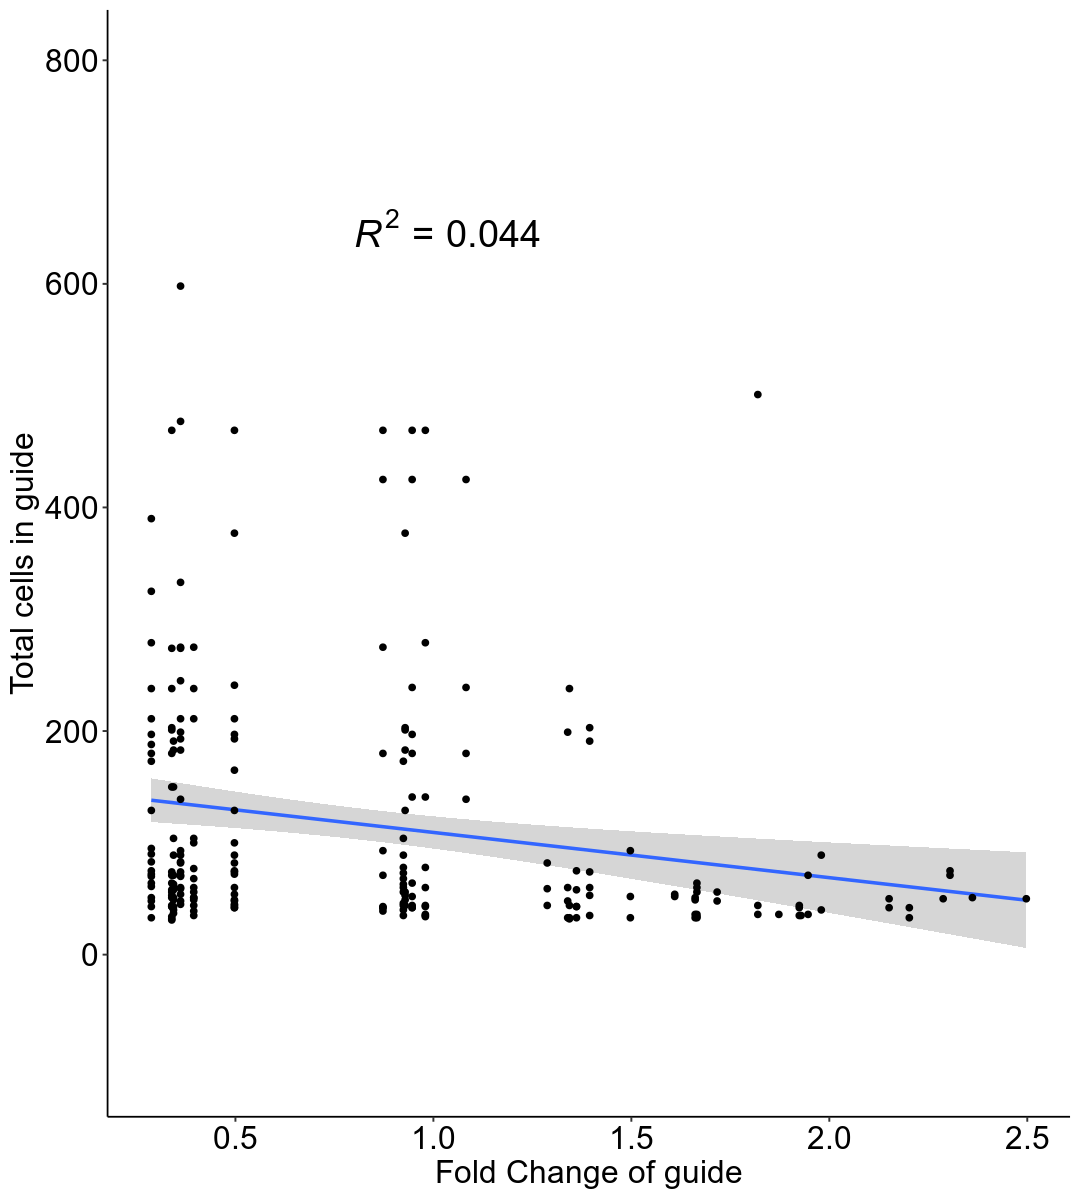

In [ ]:
## show that fold change is not a function of (related to) total cells in a guide
corr_df = bind_rows(mitosis_scores_bottom_guides_combined_w_pvals, mitosis_scores_top_guides_combined_w_pvals)
corr_df = corr_df %>% select(guide, ratio_above_noise_floor) %>% filter(!startsWith(guide, 'random_'))
corr_df$guide = stringr::str_sub(corr_df$guide, 1, -3)
corr_df$size = corr_df$guide
corr_df$size = plyr::mapvalues(corr_df$size, from = names(table(adata.R@meta.data$guide)), to = as.numeric(table(adata.R@meta.data$guide)))
corr_df$ratio_above_noise_floor = as.numeric(abs(corr_df$ratio_above_noise_floor))
corr_df$size = as.numeric(corr_df$size)
saveRDS(corr_df, '/home/ssobti/projects/mir_tud/fig_output/data/fig3/tRF_mitosis_fc_total_cells_corr_df.rds')

ggplot(data = corr_df, aes(x = ratio_above_noise_floor, y = size)) +
    geom_smooth(method = "lm", formula = y ~ x) + geom_point() + xlab('Fold Change of guide') + ylab('Total cells in guide') +
    stat_cor(aes(label = ..rr.label..), label.y = 650, label.x = 0.8, size = 8) + ylim(c(-100, 800)) + theme_pubr() + 
    theme(text = element_text(size = 19))